## Periphery Structure

In this section, we identify the **periphery nodes** in the network — these are the most distant nodes in terms of shortest path length. They lie on the edge of the graph, having the highest eccentricity.

These nodes often represent **isolated or niche playlists** that are less integrated with the core of the network.

We used NetworkX's built-in `eccentricity` and `periphery` functions to extract these nodes and highlighted them in red in the network visualization.


In [7]:
import sys
sys.path.append('../')

import utils
import networkx as nx
import matplotlib as mpl
import seaborn as sns
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches


np.random.seed(42)
plt.style.use('../style.mpl')

In [8]:
# Load the network graph from file and print basic info
G = utils.load_network(path="../data/network.pkl")
print(G)

Graph with 1139 nodes and 17908 edges


In [9]:
# Detect communities
communities = list(greedy_modularity_communities(G))
for idx, members in enumerate(communities):
    print(f"\nCommunity {idx+1} — {len(members)} artists:")
    print(", ".join(sorted(members)))
    print("-" * 80)

print(f"Detected {len(communities)} communities")


Community 1 — 428 artists:
#1 Dads, 2 Chainz, 21 Savage, 311, 50 Cent, 6LACK, A Boogie Wit da Hoodie, A R I Z O N A, A$AP Ferg, A$AP Rocky, Ace Hood, Action Bronson, Adele, Aer, Akon, Alan Walker, Alessia Cara, Alesso, Alex Newell, Alina Baraz, Alok, Amber Run, Aminé, Andy Grammer, Arctic Monkeys, Ariana Grande, Atreyu, Audien, Autograf, Avenged Sevenfold, Avicii, Avid Dancer, Avril Lavigne, B.o.B, BABE, Baby Bash, Bad Meets Evil, Bas, Bastille, Bebe Rexha, Beck, Beyoncé, Big Sean, Birdy, Blackstreet, Bobby Brackins, Bobby Shmurda, Bombay Bicycle Club, Brad Paisley, Brandy, Britney Spears, Bruce Springsteen, Bruno Mars, Bryson Tiller, BØRNS, CAZZETTE, Ca$h Out, Calvin Harris, Cash Cash, Chance The Rapper, Charlie Puth, Chet Faker, Chief Keef, Childish Gambino, Chose, Chris Brown, Clean Bandit, Coast Modern, Cold Chisel, Cold War Kids, Coldplay, Collective Soul, Colony House, Crowded House, Cypress Hill, DJ Drama, DJ Khaled, DJ Snake, DRAM, DVBBS, Daniel Caesar, Daniel Powter, Daryl Ha

In [10]:
# Identify periphery nodes (nodes with maximum eccentricity, i.e., farthest from all others)
periphery_nodes = nx.periphery(G)
print(f"Found {len(periphery_nodes)} periphery nodes.")

# Detect communities and map each node to its community index
communities = list(greedy_modularity_communities(G))
print(f"Detected {len(communities)} communities")

node_to_community = {}
for community_idx, community_members in enumerate(communities):
    for node in community_members:
        node_to_community[node] = community_idx

# Count how many periphery nodes are in each community
periphery_community_ids = [node_to_community[node] for node in periphery_nodes]
count_by_community = Counter(periphery_community_ids)

print("Periphery nodes by community:")
for comm_id, count in count_by_community.most_common():
    print(f"Community {comm_id}: {count} periphery nodes")

Found 10 periphery nodes.
Detected 11 communities
Periphery nodes by community:
Community 3: 9 periphery nodes
Community 6: 1 periphery nodes


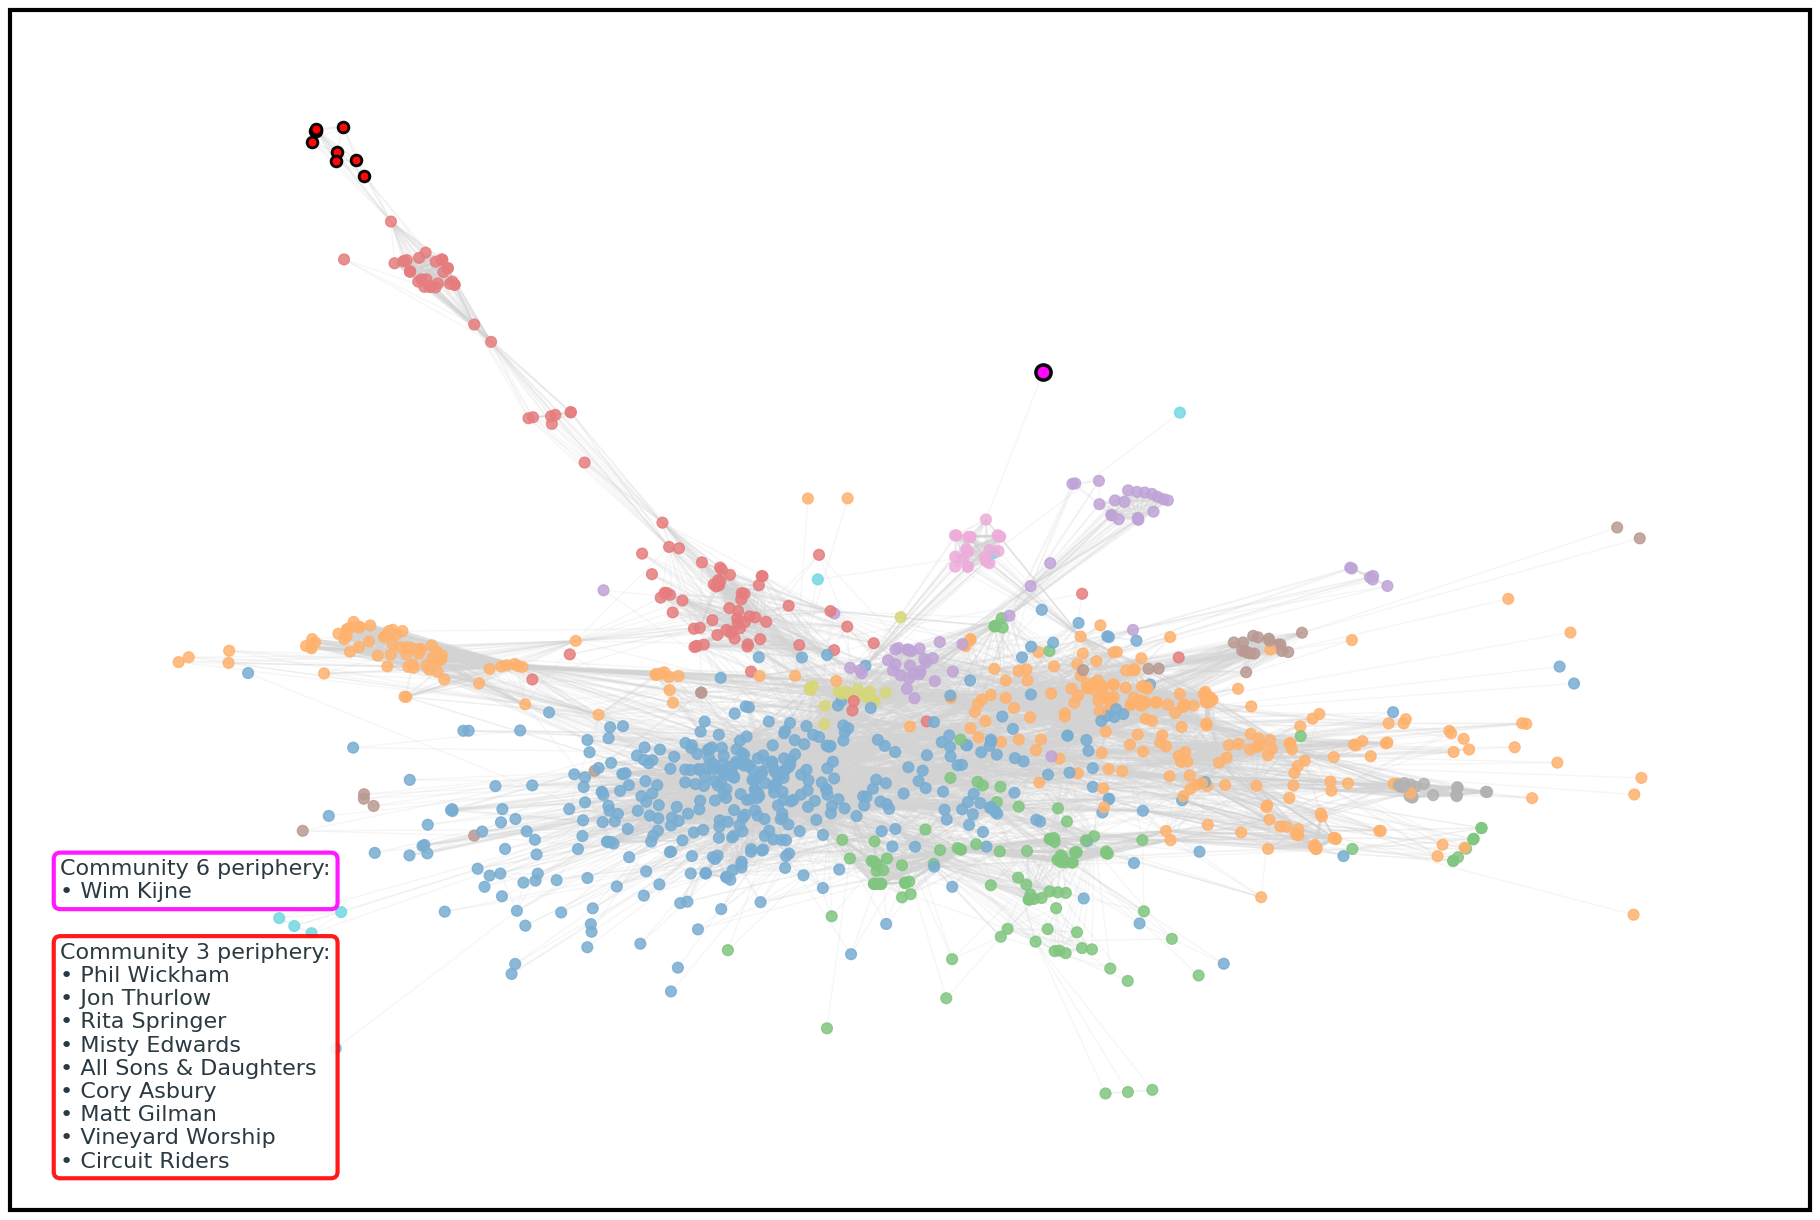

In [11]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Define node positions and sizes
pos = nx.spring_layout(G, seed=42)
node_sizes = [60 for _ in G.nodes()]  # or use another logic for sizing

# Define color map
cmap = plt.get_cmap("tab10")

# Split periphery nodes by community
community6_periphery = [n for n in periphery_nodes if node_to_community[n] == 6]
other_periphery = [n for n in periphery_nodes if node_to_community[n] != 6]

# Lighten color utility
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.
    amount=0.0 returns original color, amount=1.0 returns white.
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = np.array(mcolors.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

# Prepare lighter node colors for non-periphery nodes
lighter_node_colors = []
for n in G.nodes():
    comm_id = node_to_community[n]
    base_color = cmap(comm_id)
    if n not in periphery_nodes:
        lighter_node_colors.append(lighten_color(base_color, amount=0.4))
    else:
        lighter_node_colors.append(base_color)  # Will be overridden by periphery drawing

plt.figure(figsize=(18, 12))

# Draw all non-periphery nodes in their lighter community color
non_periphery_nodes = [n for n in G.nodes() if n not in periphery_nodes]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=non_periphery_nodes,
    node_color=[lighter_node_colors[list(G.nodes()).index(n)] for n in non_periphery_nodes],
    node_size=[node_sizes[list(G.nodes()).index(n)] for n in non_periphery_nodes],
    alpha=0.85
)

# Draw periphery nodes (except community 6) in red with black border
nx.draw_networkx_nodes(
    G, pos,
    nodelist=other_periphery,
    node_color='red',
    node_size=60,
    edgecolors='black',
    linewidths=2,
    alpha=0.97
)

# Draw community 6 periphery nodes in magenta, larger, with black border
nx.draw_networkx_nodes(
    G, pos,
    nodelist=community6_periphery,
    node_color='magenta',
    node_size=120,
    edgecolors='black',
    linewidths=2.5,
    alpha=0.97
)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.2)

# Build legends for two selected communities (3 and 6)
legend_communities = {
    3: {'color': 'red', 'label': "Community 3"},
    6: {'color': 'magenta', 'label': "Community 6"}
}
legend_text = []
for comm_id, props in legend_communities.items():
    periphery_list = [n for n in communities[comm_id] if n in periphery_nodes]
    if periphery_list:
        legend_text.append(f"{props['label']} periphery:\n" + "\n".join(f"• {n}" for n in periphery_list))
    else:
        legend_text.append(f"{props['label']} periphery:\n(none)")

plt.text(
    0.02, 0.02, legend_text[0],  # bottom left
    transform=plt.gca().transAxes,
    fontsize=16,
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='red', linewidth=3, alpha=0.9)
)
if len(legend_text) > 1:
    plt.text(
        0.02, 0.25, legend_text[1],  # higher for the second legend
        transform=plt.gca().transAxes,
        fontsize=16,
        verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='magenta', linewidth=3, alpha=0.9)
    )

plt.tight_layout()

# Add a black border around the entire figure
fig = plt.gcf()
rect = patches.Rectangle(
    (0, 0), 1, 1, transform=fig.transFigure,
    linewidth=3, edgecolor='black', facecolor='none', zorder=1000
)
fig.patches.append(rect)

# Finalize and save
plt.axis("off")
plt.tight_layout()
plt.savefig("../plots/periphery-nodes-highlighted.png", transparent=True)
plt.show()

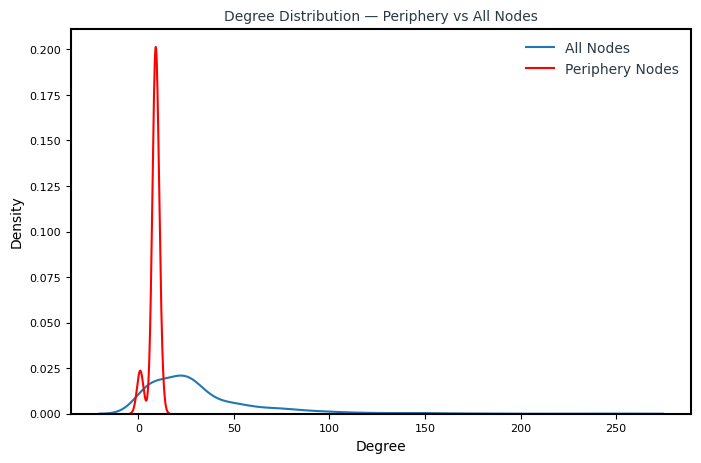

In [12]:
# Compare degree distributions: periphery nodes vs all nodes

# Get degree for each node in the graph
deg_dict = dict(G.degree())

# Extract degree values for periphery nodes and all nodes
periphery_degrees = [deg_dict[n] for n in periphery_nodes]
all_degrees = list(deg_dict.values())

# Plot degree distributions using kernel density estimation
plt.figure(figsize=(8, 5))
sns.kdeplot(all_degrees, label="All Nodes")
sns.kdeplot(periphery_degrees, label="Periphery Nodes", color='red')
plt.xlabel("Degree")
plt.title("Degree Distribution — Periphery vs All Nodes")
plt.legend()

# Save and show the plot
plt.savefig("../plots/degree-distribution-periphery.png", transparent=True)
plt.show()